In [ ]:
import dolfinx
import dolfinx.fem.petsc
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import ufl
from mpi4py import MPI
from petsc4py import PETSc


def q(u):
    return 1 + u**2


domain = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
x = ufl.SpatialCoordinate(domain)
u_ufl = 1 + x[0] + 2 * x[1]
f = - ufl.div(q(u_ufl) * ufl.grad(u_ufl))


def u_exact(x):
    return eval(str(u_ufl))

N = 50

mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, N)
V = dolfinx.fem.functionspace(domain, ("Lagrange", 1))
u_D = dolfinx.fem.Function(V)
u_D.interpolate(u_exact)
fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, fdim + 1)
boundary_facets = dolfinx.mesh.exterior_facet_indices(domain.topology)
bc = dolfinx.fem.dirichletbc(u_D, dolfinx.fem.locate_dofs_topological(V, fdim, boundary_facets))

uh = dolfinx.fem.Function(V)
v = ufl.TestFunction(V)
F = q(uh) * ufl.dot(ufl.grad(uh), ufl.grad(v)) * ufl.dx - f * v * ufl.dx
J = ufl.derivative(F, uh)
residual = dolfinx.fem.form(F)
jacobian = dolfinx.fem.form(J)


du = dolfinx.fem.Function(V)
A = dolfinx.fem.petsc.create_matrix(jacobian)
L = dolfinx.fem.petsc.create_vector(residual)
solver = PETSc.KSP().create(mesh.comm)
solver.setOperators(A)


i = 0
error = dolfinx.fem.form(ufl.inner(uh - u_ufl, uh - u_ufl) * ufl.dx(metadata={"quadrature_degree": 4}))
L2_error = []
du_norm = []
max_iterations = 50
while i < max_iterations:
    # Assemble Jacobian and residual
    with L.localForm() as loc_L:
        loc_L.set(0)
    A.zeroEntries()
    dolfinx.fem.petsc.assemble_matrix(A, jacobian, bcs=[bc])
    A.assemble()
    dolfinx.fem.petsc.assemble_vector(L, residual)
    L.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    L.scale(-1)

    # Compute b - J(u_D-u_(i-1))
    dolfinx.fem.petsc.apply_lifting(L, [jacobian], [[bc]], x0=[uh.x.petsc_vec], alpha=1)
    # Set du|_bc = u_{i-1}-u_D
    dolfinx.fem.petsc.set_bc(L, [bc], uh.x.petsc_vec, 1.0)
    L.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES, mode=PETSc.ScatterMode.FORWARD)

    # Solve linear problem
    solver.solve(L, du.x.petsc_vec)
    du.x.scatter_forward()

    # Update u_{i+1} = u_i + delta u_i
    uh.x.array[:] += du.x.array
    i += 1

    # Compute norm of update
    correction_norm = du.x.petsc_vec.norm(0)

    # Compute L2 error comparing to the analytical solution
    L2_error.append(np.sqrt(mesh.comm.allreduce(dolfinx.fem.assemble_scalar(error), op=MPI.SUM)))
    du_norm.append(correction_norm)

    print(f"Iteration {i}: Correction norm {correction_norm}, L2 error: {L2_error[-1]}")
    if correction_norm < 1e-10:
        break



Iteration 1: Correction norm 217.42584709370274, L2 error: 1.009448688612128
Iteration 2: Correction norm 154.60849040249565, L2 error: 1.0258856372523797
Iteration 3: Correction norm 49.272468293730036, L2 error: 0.35418859182768125
Iteration 4: Correction norm 16.956120024679954, L2 error: 0.07129373825039684
Iteration 5: Correction norm 3.1667978794494136, L2 error: 0.004565047012091511
Iteration 6: Correction norm 0.1713648411561298, L2 error: 2.6269980227761826e-05
Iteration 7: Correction norm 0.0008143265267745705, L2 error: 1.2302021573156137e-09
Iteration 8: Correction norm 3.734667277924273e-08, L2 error: 7.051518974089328e-15
Iteration 9: Correction norm 5.464121359529486e-13, L2 error: 2.7655158709545935e-16


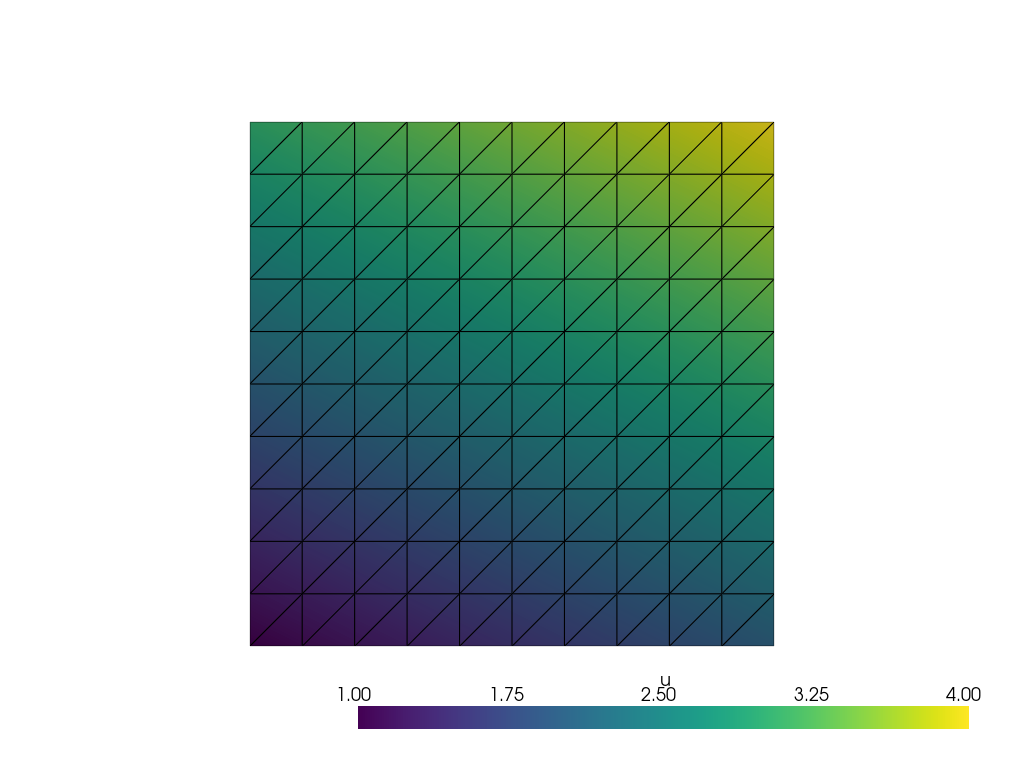

In [17]:
import pyvista 
pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry = dolfinx.plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

--- Starting Newton Solver with Custom Problem Class ---
Converged in 3 iterations.


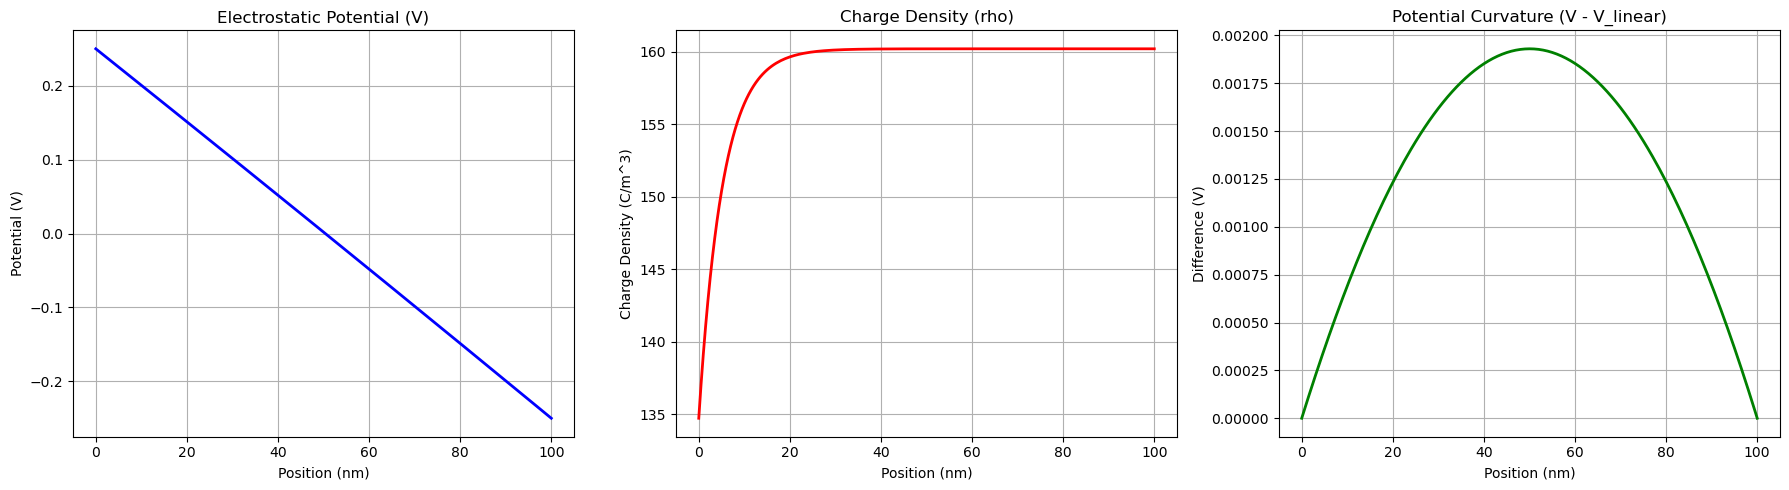

In [ ]:
import dolfinx
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc

import matplotlib.pyplot as plt

# --- Physical Constants
q = 1.602e-19  # Elementary charge
k_B = 1.380e-23 # Boltzmann constant
T = 300.0      # Temperature in Kelvin
epsilon_0 = 8.854e-12 # Vacuum permittivity
epsilon_r = 11.7     # Relative permittivity of Silicon
eps = epsilon_r * epsilon_0
n_i = 1.0e16         # Intrinsic carrier concentration in Si (m^-3)
N_D = 1.0e21         # Donor doping concentration (m^-3)
thermal_voltage = k_B * T / q


mesh_size = 200
device_length = 100e-9
mesh = dolfinx.mesh.create_interval(MPI.COMM_WORLD, mesh_size, [0, device_length])
V_space = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))


class PoissonBoltzmannProblem(dolfinx.fem.petsc.NonlinearProblem):
    """Custom class for the nonlinear Poisson-Boltzmann problem."""
    def __init__(self, F, J, u, rho, drho_dv, bcs):
        super().__init__(F, u, bcs=bcs, J=J)
        self._rho = rho
        self._drho_dv = drho_dv
        self._u = u

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual vector F(x, b)."""

        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()


        potential_values = self._u.x.array
        self._rho.x.array[:] = q * (N_D - n_i * np.exp(potential_values / thermal_voltage)) 
        self._rho.x.scatter_forward()

        super().F(x, b)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        """Assemble the Jacobian matrix J(x, A)."""

        potential_values = self._u.x.array
        self._drho_dv.x.array[:] = -q * (n_i / thermal_voltage) * np.exp(potential_values / thermal_voltage) 
        self._drho_dv.x.scatter_forward()

        super().J(x, A)

Vh = dolfinx.fem.Function(V_space, name="Potential")
rho_h = dolfinx.fem.Function(V_space, name="ChargeDensity")
d_rho_dV_h = dolfinx.fem.Function(V_space, name="ChargeDensityDerivative")


v = ufl.TestFunction(V_space)
F = eps * ufl.dot(ufl.grad(Vh), ufl.grad(v)) * ufl.dx - rho_h * v * ufl.dx
J = ufl.derivative(F, Vh, ufl.TrialFunction(V_space))

V_left = 0.25
V_right = -0.25

fdim = mesh.topology.dim - 1
left_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], 0))
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], device_length))

left_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, left_facets)
right_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, right_facets)

bc_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_left), left_dofs, V_space)
bc_right = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_right), right_dofs, V_space)
bcs = [bc_left, bc_right]

problem = PoissonBoltzmannProblem(F, J, Vh, rho_h, d_rho_dV_h, bcs)

solver = dolfinx.nls.petsc.NewtonSolver(mesh.comm, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.max_it = 50

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"

opts["snes_linesearch_type"] = "basic"

ksp.setFromOptions()

Vh.interpolate(lambda x: V_left + (V_right - V_left) * x[0] / device_length)

print("--- Starting Newton Solver with Custom Problem Class ---")
n, converged = solver.solve(Vh)
if converged:
    print(f"Converged in {n} iterations.")
else:
    print(f"Solver did not converge in {n} iterations.")

if MPI.COMM_WORLD.rank == 0:

    x_coords = V_space.tabulate_dof_coordinates()[:, 0]
    sort_order = np.argsort(x_coords)
    x_sorted = x_coords[sort_order]
    V_sorted = Vh.x.array[sort_order]
    rho_sorted = rho_h.x.array[sort_order]

    linear_potential = V_left + (V_right - V_left) * x_sorted / device_length
    potential_difference = V_sorted - linear_potential

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.plot(x_sorted * 1e9, V_sorted, lw=2, color='blue')
    ax1.set_title("Electrostatic Potential (V)")
    ax1.set_xlabel("Position (nm)")
    ax1.set_ylabel("Potential (V)")
    ax1.grid(True)

    ax2.plot(x_sorted * 1e9, rho_sorted, lw=2, color='red')
    ax2.set_title("Charge Density (rho)")
    ax2.set_xlabel("Position (nm)")
    ax2.set_ylabel("Charge Density (C/m^3)")
    ax2.grid(True)

    ax3.plot(x_sorted * 1e9, potential_difference, lw=2, color='green')
    ax3.set_title("Potential Curvature (V - V_linear)")
    ax3.set_xlabel("Position (nm)")
    ax3.set_ylabel("Difference (V)")
    ax3.grid(True)
    
    fig.tight_layout()
    plt.show()


--- Starting Newton Solver for 2D Problem ---
Converged in 2 iterations.


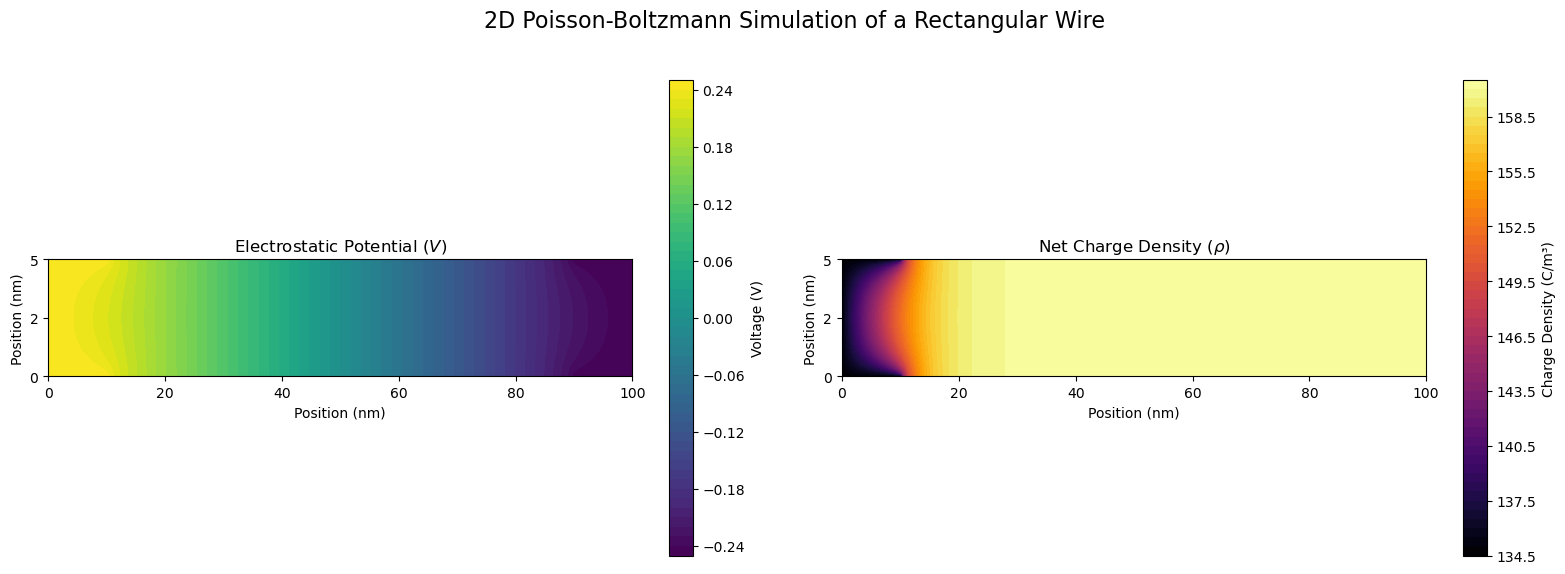

In [ ]:
import dolfinx
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc

import matplotlib.pyplot as plt
import matplotlib.tri as tri

# --- Physical Constants
q = 1.602e-19       # Elementary charge (C)
k_B = 1.380e-23     # Boltzmann constant (J/K)
T = 300.0           # Temperature (K)
epsilon_0 = 8.854e-12 # Vacuum permittivity (F/m)
epsilon_r = 11.7      # Relative permittivity of Silicon
eps = epsilon_r * epsilon_0
n_i = 1.0e16          # Intrinsic carrier concentration in Si (m^-3)
N_D = 1.0e21          # Donor doping concentration (m^-3)
thermal_voltage = k_B * T / q

# --- 2D Geometry Definition
device_length = 100e-9 # Length in x-direction (m)
device_width = 20e-9   # Width in y-direction (m)
mesh_size_x = 200      # Number of elements in x
mesh_size_y = 40       # Number of elements in y

# --- Create a 2D Rectangular Mesh
mesh = dolfinx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([device_length, device_width])],
    [mesh_size_x, mesh_size_y],
    cell_type=dolfinx.mesh.CellType.triangle
)
V_space = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

# --- Custom Nonlinear Problem Class (No changes needed)
class PoissonBoltzmannProblem(dolfinx.fem.petsc.NonlinearProblem):
    """Custom class for the nonlinear Poisson-Boltzmann problem."""
    def __init__(self, F, J, u, rho, drho_dv, bcs):
        super().__init__(F, u, bcs=bcs, J=J)
        self._rho = rho
        self._drho_dv = drho_dv
        self._u = u

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual vector F(x, b)."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()

        potential_values = self._u.x.array
        self._rho.x.array[:] = q * (N_D - n_i * np.exp(potential_values / thermal_voltage))
        self._rho.x.scatter_forward()
        
        with b.localForm() as b_loc:
            b_loc.set(0)
        dolfinx.fem.petsc.assemble_vector(b, self._L)
        dolfinx.fem.apply_lifting(b, [self._a], [self.bcs], [x], -1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(b, self.bcs, x, -1.0)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        """Assemble the Jacobian matrix J(x, A)."""
        potential_values = self._u.x.array
        self._drho_dv.x.array[:] = -q * (n_i / thermal_voltage) * np.exp(potential_values / thermal_voltage)
        self._drho_dv.x.scatter_forward()
        
        A.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(A, self._a, self.bcs)
        A.assemble()


# --- UFL Formulation (No changes needed for 2D)
Vh = dolfinx.fem.Function(V_space, name="Potential")
rho_h = dolfinx.fem.Function(V_space, name="ChargeDensity")
d_rho_dV_h = dolfinx.fem.Function(V_space, name="ChargeDensityDerivative")

v = ufl.TestFunction(V_space)
# The term rho_h must be on the LHS for the derivative to be computed correctly
F = eps * ufl.dot(ufl.grad(Vh), ufl.grad(v)) * ufl.dx + rho_h * v * ufl.dx
J = ufl.derivative(F, Vh, ufl.TrialFunction(V_space))

# --- Boundary Conditions
V_S = 0.25  # Source voltage on the left
V_D = -0.25 # Drain voltage on the right

# Helper functions to locate boundaries
def left_boundary(x):
    return np.isclose(x[0], 0)

def right_boundary(x):
    return np.isclose(x[0], device_length)

# NOTE: Top and bottom have zero Neumann conditions (dV/dn = 0), which are
# natural boundary conditions in this formulation. They are satisfied automatically
# if we don't specify any other condition on those boundaries.

fdim = mesh.topology.dim - 1 # fdim = 1 for edges in a 2D mesh
left_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, left_boundary)
right_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, right_boundary)

left_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, left_facets)
right_dofs = dolfinx.fem.locate_dofs_topological(V_space, fdim, right_facets)

bc_left = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_S), left_dofs, V_space)
bc_right = dolfinx.fem.dirichletbc(PETSc.ScalarType(V_D), right_dofs, V_space)
bcs = [bc_left, bc_right]

# --- Setup Solver
problem = dolfinx.fem.petsc.NonlinearProblem(F, Vh, bcs=bcs, J=J)

solver = dolfinx.nls.petsc.NewtonSolver(mesh.comm, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.max_it = 50

# Configure solver options
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps" # Use a robust direct solver
ksp.setFromOptions()

# --- Initial Guess and Solve
# Linear interpolation between source and drain voltage
Vh.interpolate(lambda x: V_S + (V_D - V_S) * x[0] / device_length)

print("--- Starting Newton Solver for 2D Problem ---")
n, converged = solver.solve(Vh)
if converged:
    print(f"Converged in {n} iterations.")
else:
    print(f"Solver did not converge in {n} iterations.")

# --- Post-Processing and Visualization
if MPI.COMM_WORLD.rank == 0:
    # Get coordinates and solution values for plotting
    coords = V_space.tabulate_dof_coordinates()
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Update the charge density function 'rho_h' with the final potential
    potential_values = Vh.x.array
    rho_h.x.array[:] = q * (N_D - n_i * np.exp(potential_values / thermal_voltage))
    rho_values = rho_h.x.array
    
    # Create triangulation for plotting
    triangulation = tri.Triangulation(x_coords, y_coords)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('2D Poisson-Boltzmann Simulation of a Rectangular Wire', fontsize=16)

    # Plot Electrostatic Potential
    contour1 = ax1.tricontourf(triangulation, Vh.x.array, levels=50, cmap='viridis')
    fig.colorbar(contour1, ax=ax1, label='Voltage (V)')
    ax1.set_title("Electrostatic Potential ($V$)")
    ax1.set_xlabel("Position (nm)")
    ax1.set_ylabel("Position (nm)")
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xticklabels([f'{x*1e9:.0f}' for x in ax1.get_xticks()])
    ax1.set_yticklabels([f'{y*1e9:.0f}' for y in ax1.get_yticks()])


    # Plot Charge Density
    contour2 = ax2.tricontourf(triangulation, rho_values, levels=50, cmap='inferno')
    fig.colorbar(contour2, ax=ax2, label='Charge Density (C/m³)')
    ax2.set_title("Net Charge Density ($\\rho$)")
    ax2.set_xlabel("Position (nm)")
    ax2.set_ylabel("Position (nm)")
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_xticklabels([f'{x*1e9:.0f}' for x in ax2.get_xticks()])
    ax2.set_yticklabels([f'{y*1e9:.0f}' for y in ax2.get_yticks()])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()